AR composites (both anomaly/non-anomaly) of different variables using different cEOF tests (e.g. DJF, MAM, DJF-MAM). 

Creates a 9 panel plot with the following variables in the columns
1. (upper) 250-hPa geopotential heights (contour lines), isotachs (contour shading), and wind vectors
2. (ivt) 
3. (precip)


## Imports

In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import independent_ttest, persistence

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/composites/'      # figures


In [3]:
# Set a default font for all matplotlib text 
rcParams['font.family'] = 'sans-serif'   # font family = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # default sans-serif font = 'Arial'


## Data

In [4]:
# import configuration file for dictionary choice
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
#select dictionaries - choose var, anom/nanom, and season
# upper_ precip_ ivt_ and non_anom anom
plot_dict_upper = config['upper_anom']
plot_dict_ivt = config['ivt_anom']
plot_dict_prec = config['precip_anom']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

# djf_dict mam_dict djfmam_dict
ar_dict = config['mam']

### ERA5 renalysis

In [5]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
    else:
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

f = []
# Select lat/lon grid
lonmin = plot_dicts[1]['bnds'][0]
lonmax = plot_dicts[1]['bnds'][1]
latmin = plot_dicts[1]['bnds'][2]
latmax = plot_dicts[1]['bnds'][3]

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))


In [6]:
var_dict = {'H': (['time', 'lat', 'lon'], f[0]['z'].values/(9.80665*10)), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f[0]['u'].values),
            'V': (['time', 'lat', 'lon'], f[0]['v'].values),
            'ivte': (['time', 'lat', 'lon'], f[1]['p71.162'].values),
            'ivtn': (['time', 'lat', 'lon'], f[1]['p72.162'].values)}


ds = xr.Dataset(var_dict,
                coords={'time': (['time'], f[0]['time'].values),
                        'lat': (['lat'], f[0]['latitude'].values),
                        'lon': (['lon'], f[0]['longitude'].values)})

ds2 = xr.Dataset({'prec': (['time', 'lat', 'lon'], f[2]['mtpr'].values*86400)},
                coords={'time': (['time'], f[2]['time'].values),
                        'lat': (['lat'], f[2]['latitude'].values),
                        'lon': (['lon'], f[2]['longitude'].values)})
ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 10.68



### AR days

In [7]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-' + ar_dict['ssn'] + '.csv'
df = pd.read_csv(filepath)


In [8]:
# Trim date range
idx = slice(ar_dict['start_date'], ar_dict['end_date'])
ds = ds.sel(time=idx)
ds2 = ds2.sel(time=idx)

# Select DJF months
# Select months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
else:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    
ds = ds.sel(time=idx)
ds2 = ds2.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', df.AR_CAT)
ds = ds.set_coords('ar')

ds2['ar'] = ('time', df.AR_CAT)
ds2 = ds2.set_coords('ar')

In [9]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

In [10]:
# Lag=0, -2, +2
era_ar_lag0 = select_ar_days(era=ds, lag=0)
era_ar_lag2 = select_ar_days(era=ds, lag=-2)

# Lag=0, -2, +2
era_ar_lag02 = select_ar_days(era=ds2, lag=0)
era_ar_lag22 = select_ar_days(era=ds2, lag=-2)


# combine lag datasets into 1 ds object
era_ar_lag = xr.concat([era_ar_lag0, era_ar_lag2], pd.Index([0, 2], name='lag'))
era_ar_lag2 = xr.concat([era_ar_lag02, era_ar_lag22], pd.Index([0, 2], name='lag'))

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 181, time: 441)
Coordinates:
  * time     (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 2 2 2 1 2 1 1 3 2 3 2 1 1 ... 1 2 2 2 3 2 2 1 2 2 3 1
Data variables:
    H        (time, lat, lon) float64 5.534 5.639 5.759 ... 0.6402 0.6212 0.665
    U        (time, lat, lon) float64 -6.155 -6.8 -7.426 ... 2.62 2.485 2.068
    V        (time, lat, lon) float64 2.928 2.589 2.557 ... -3.713 -3.936 -3.679
    ivte     (time, lat, lon) float64 -36.26 -39.77 -43.7 ... -168.9 -165.4
    ivtn     (time, lat, lon) float64 20.22 18.72 17.68 ... -51.15 -47.16 -36.52
<xarray.Dataset>
Dimensions:  (lat: 101, lon: 181, time: 441)
Coordinates:
  * time     (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * lat      (lat) float32 50.0 49.5 49

### Compute AR Composites

In [11]:
# Count number of independent AR events

years = np.arange(ar_dict['ys'], ar_dict['ye']) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single season
    date1 = "{0}-{1}-{2}".format(years[k], ar_dict['mon_s'], ar_dict['day_s'])
    date2 = "{0}-{1}-{2}".format(years[k+1], ar_dict['mon_e'], ar_dict['day_e'])
    x = ds.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  191


In [12]:
# Compute composites of each AR type
era_ar_comp = era_ar_lag.groupby('ar').mean('time')
era_ar_comp1 = era_ar_lag2.groupby('ar').mean('time')

# run 1-sample t-test, mask results below 95% confidence level
if plot_dict['anom'] == 'anom':
    tval_mask, pval_mask = independent_ttest(ds=era_ar_lag, group='ar', alpha=0.05, df=total_events-2)
    era_ar_comp = era_ar_comp.where(tval_mask == True)
    
    tval_mask, pval_mask = independent_ttest(ds=era_ar_lag2, group='ar', alpha=0.05, df=total_events-2)
    era_ar_comp1 = era_ar_comp1.where(tval_mask == True)
else:
    era_ar_comp = era_ar_comp
    era_ar_comp1 = era_ar_comp1


Critical t-value:  1.6529558017250379
Critical t-value:  1.6529558017250379


### Figures

### Common Plot Properties

In [13]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# 9-panel plot    
panel_9 = {'nrows': 3,
            'ncols': 3,
            'artype_lst': [3, 1, 2],
            'panel': '9pan'}

panel_dict = panel_9

### Composite Plots

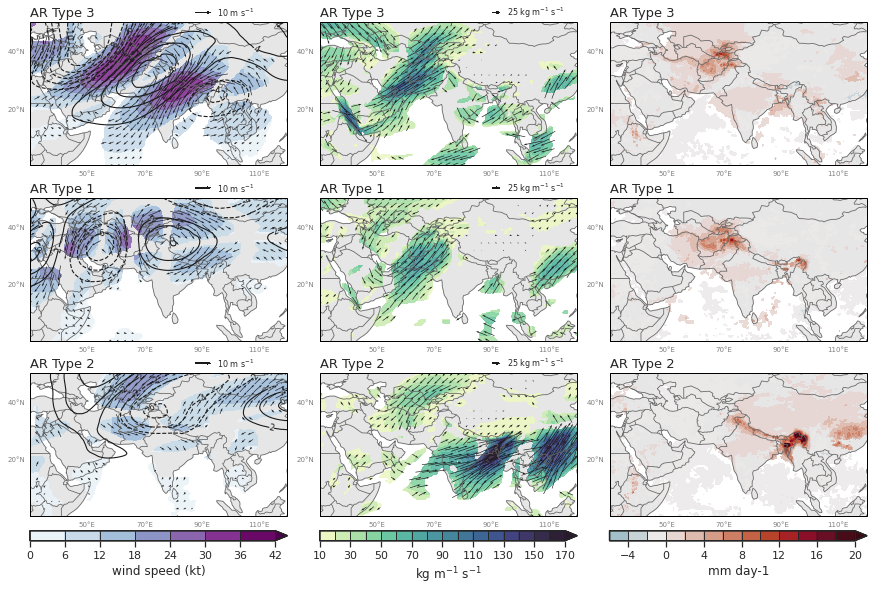

In [14]:
fig_dict = panel_dict
filepath = path_to_figs + plot_dict['anom'] + '/' + 'HUV500_' +  'ALL_' + ar_dict['ssn'] + fig_dict['panel'] + '.png'
nrows = fig_dict['nrows']
ncols = fig_dict['ncols']
artype_lst = fig_dict['artype_lst']

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.20, cbar_size='7%',label_mode='',
                direction='column')

#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:3], artype_lst)):
    data = era_ar_comp.sel(ar=ar_type, lag=0)
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled

    # 250-hPa Winds (m/s)
    uwnd = data.U.values * units('m/s')
    vwnd = data.V.values * units('m/s')
    wspd = mpcalc.wind_speed(uwnd, vwnd)
    # 250-hPa Winds (knots)
    uwnd_kt = wspd.to('kt')
    vwnd_kt = wspd.to('kt')
    wspd_kt = wspd.to('kt')
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max')
    
    # Contour Lines

    # 250-hPa Heights
    hgts = data.H.values
    clevs = np.arange(plot_dict['clevs'][0], plot_dict['clevs'][1], plot_dict['clevs'][2])
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                  color='k', regrid_shape=20, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                     coordinates='axes', fontproperties={'size': 8.0})
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[3:6], artype_lst)):
    data = era_ar_comp.sel(ar=ar_type, lag=0)
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=20, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## PREC PLOTS ##########
################################

for k, (ax, ar_type) in enumerate(zip(axgr[6:], artype_lst)):
    data = era_ar_comp1.sel(ar=ar_type, lag=0)
    plot_dict = plot_dict_prec
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled

    # Precip (filled contour)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    if plot_dict['anom'] == 'anom':
        cmap = cmocean.tools.crop(cmo.balance, vmin=-6., vmax=22., pivot=0., N=None, dmax=None)
    if plot_dict['anom'] == 'nanom':
        cmap = plot_dict['cmap']
    prec = data.prec.values
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[2], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
